In [1]:
from pathlib import Path
from sklearn.linear_model import LogisticRegression
# from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from typing import List
import sys


sys.path.append("../")

from src.common_functions import *

In [2]:
# sample data
RAW_DATA_PATH = "../datasets/fraud/vehicle_fraud.csv"
DATASET_NAME = Path(RAW_DATA_PATH).stem
df = pd.read_csv(RAW_DATA_PATH)
df = df.rename(columns=dict(zip(df.columns, list(map(to_snake_case, df.columns)))))
df.head()
print(df.shape[0])
df["fraud_found_p"].value_counts()/df.shape[0]*100

15420


fraud_found_p
0    94.014267
1     5.985733
Name: count, dtype: float64

In [3]:
df.isna().any()

month                    False
week_of_month            False
day_of_week              False
make                     False
accident_area            False
day_of_week_claimed      False
month_claimed            False
week_of_month_claimed    False
sex                      False
marital_status           False
age                      False
fault                    False
policy_type              False
vehicle_category         False
vehicle_price            False
fraud_found_p            False
policy_number            False
rep_number               False
deductible               False
driver_rating            False
days_policy_accident     False
days_policy_claim        False
past_number_of_claims    False
age_of_vehicle           False
age_of_policy_holder     False
police_report_filed      False
witness_present          False
agent_type               False
number_of_suppliments    False
address_change_claim     False
number_of_cars           False
year                     False
base_pol

In [4]:
df.value_counts(["make", "fraud_found_p"])

make       fraud_found_p
Pontiac    0                3624
Toyota     0                2935
Honda      0                2622
Mazda      0                2231
Chevrolet  0                1587
Ford       0                 417
Accura     0                 413
VW         0                 275
Pontiac    1                 213
Toyota     1                 186
Honda      1                 179
Mazda      1                 123
Dodge      0                 107
Saab       0                  97
Chevrolet  1                  94
Mercury    0                  77
Accura     1                  59
Saturn     0                  52
Ford       1                  33
Nisson     0                  29
BMW        0                  14
Saab       1                  11
VW         1                   8
Jaguar     0                   6
Saturn     1                   6
Mercury    1                   6
Porche     0                   5
Mecedes    0                   3
Ferrari    0                   2
Dodge      1      

In [5]:
df[sorted(df.columns)].dtypes

accident_area            object
address_change_claim     object
age                       int64
age_of_policy_holder     object
age_of_vehicle           object
agent_type               object
base_policy              object
day_of_week              object
day_of_week_claimed      object
days_policy_accident     object
days_policy_claim        object
deductible                int64
driver_rating             int64
fault                    object
fraud_found_p             int64
make                     object
marital_status           object
month                    object
month_claimed            object
number_of_cars           object
number_of_suppliments    object
past_number_of_claims    object
police_report_filed      object
policy_number             int64
policy_type              object
rep_number                int64
sex                      object
vehicle_category         object
vehicle_price            object
week_of_month             int64
week_of_month_claimed     int64
witness_

In [6]:
y = "fraud_found_p"

# some generic cleaning
df = df.loc[df.day_of_week_claimed!=0]
df = df.loc[df.policy_type!="Sport - Liability"]
df["vehicle_price"] = df["vehicle_price"].str.replace("less than ", "").str.replace("more than ", "").str.split(" to").str[0].astype(int)
df["past_number_of_claims"]= df["past_number_of_claims"].str.replace("none", "0").str.replace("more than ", "").str.split("").str[1:3].str.join("").str.strip().astype(int)
df["days_policy_claim"] = df["days_policy_claim"].str.replace("none", "0").str.replace("more than ", "").str.split("").str[1:3].str.join("").str.strip().astype(int)
df["days_policy_accident"] = df["days_policy_accident"].str.replace("none", "0").str.replace("more than ", "").str.split("").str[1:3].str.join("").str.strip().astype(int)
df["age_of_vehicle"] = df["age_of_vehicle"].str.replace("new", "0").str.replace("more than ", "").str.split("").str[1].astype(int)
df["age_of_policy_holder"] = df["age_of_policy_holder"].str.replace("over ", "").str.split("").str[1:3].str.join("").astype(int)
df["address_change_claim"] = df["address_change_claim"].str.split("").str[1].str.replace("n", "0").str.replace("u", "0.25").astype(float)
df["number_of_suppliments"] = df["number_of_suppliments"].str.split("").str[1].str.replace("n", "0").str.replace("m", "5").astype(int)
df['number_of_cars'] = df.number_of_cars.str.split("").str[1].str.replace("m", "8")
df["number_of_cars_as_int"] = df["number_of_cars"].str.split("").str[1].str.replace("m", "8").astype(int)
COLUMNS_TO_DROP = ["address_change_claim", "number_of_cars", "policy_number"]
assert df[y].isna().any() == False
# drop single row with Lexus as encoder can't handle cases seen in only train, while encoding test
drop_condition = ((df.make.isin(["Lexus", "Ferrari", "Mecedes"])) | (
    df.make.isin(["BMW", "Nisson", "Mecedes", "Dodge"]) & (df[y] == 1)))
raw_features = df.drop(
    COLUMNS_TO_DROP, axis=1).loc[~drop_condition]

# ML tuning
# add make otherwise there are unknown brands in test set, and encoder can't handle
train, test = train_test_split(
    raw_features, test_size=0.2, random_state=0, stratify=raw_features[[y, "make"]])

fit_le = LabelEncoder().fit(train[y])

In [7]:
df.shape[0] - raw_features.shape[0]

11

In [8]:
# def build_column_transformer_for_df(train_x: pd.DataFrame, text_columns:List[str]) -> ColumnTransformer:
#     """Builds a column transformer for a pandas dataframe."""
#     # Get the categorical and numerical columns
#     categorical_columns = train_x.select_dtypes(
#         include='object').columns.to_list()
#     numerical_columns = train_x.select_dtypes(
#         include='number').columns.to_list()

#     num_prep = Pipeline(steps=[
#         ('num_imputer', SimpleImputer(strategy='median')),
#         ('scaler', StandardScaler())
#     ])

#     cat_prep = Pipeline(steps=[
#         ('cat_imputer', SimpleImputer(strategy='most_frequent')),
#         ('encoder', OneHotEncoder(sparse_output=False))
#     ])

#     transformer = ColumnTransformer([
#         ('text', TfidfVectorizer(), text_columns),
#         ('num', num_prep, numerical_columns),
#         ('cat', cat_prep, categorical_columns)
#     ])

#     return transformer

In [9]:
# pipeline = build_sklearn_pipeline(train, y, model_name="logistic", model=LogisticRegression())
# pipeline.fit(train.drop(y, axis=1), train[y])

In [10]:
param_grid = {
    'logistic__penalty': ['l2'],
    'logistic__C': [1, 10, 100, 1000],
    'pca__n_components': list(range(6, 32, 8)),
    'under__sampling_strategy': [0.1, 0.2, 0.3, 0.5, 0.7, 1],
    'over__sampling_strategy': [0.2, 0.3, 0.4, 0.5, 0.7, 1]
}

model = LogisticRegression()

MODEL_NAME = 'logistic'

# text_columns = ["address_change_claim"]

# steps = build_column_transformer_for_df(
#     train_x=train.drop(y, axis=1))._transformers
# steps.insert(0, ('text', TfidfVectorizer(), [text_column]))
# preprocessor = ColumnTransformer(steps)

# preprocessor = build_column_transformer_for_df(train.drop(y, axis=1), text_columns)
# pipeline = build_sklearn_pipeline(
#     train, y_col_name=y, model_name=MODEL_NAME, model=model, transformer=preprocessor)
grid = sklearn_gridsearch_using_pipeline(train, y_col_name=y, model_name=MODEL_NAME,
                                  model=model, fit_le=fit_le, param_grid=param_grid, verbose=1, n_folds=5) #, pipeline=pipeline)
best_pipeline_log_reg = grid.best_estimator_
best_pipeline_log_reg

Fitting 5 folds for each of 576 candidates, totalling 2880 fits


/home/maarten/.local/share/virtualenvs/End-to-end-project---Customer-churn-PLUo0CZ0/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
1440 fits failed out of a total of 2880.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1440 fits failed with the following error:
Traceback (most recent call last):
  File "/home/maarten/.local/share/virtualenvs/End-to-end-project---Customer-churn-PLUo0CZ0/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/maarten/.local/share/virtualenvs/End-to-end-project---Customer-churn-PLUo0CZ0/lib/python3.11/site-packages/imblearn/pipeline.py", line 293, in fit
   

Best score: 0.7762963745222107
Best parameters: {'logistic__C': 100, 'logistic__penalty': 'l2', 'over__sampling_strategy': 1, 'pca__n_components': 22, 'under__sampling_strategy': 0.7}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['week_of_month',
                                                   'week_of_month_claimed',
                                                   'age', 'vehicle_price',
                                                   'rep_number', 'deductible',
                                                   'driver_rating',
                                                   'days_policy_accident',
                                                   'days_policy_claim',
                                                   'past_number_of_claims',
                                                   'age_of_vehi...
                                                   'make', 'accident_area',
                                                   'day_of_week_claimed',
                                                   'month_claimed', 'sex',
                                                   'marital_status', 'fault',
                                                   'policy_type',
                                                   'vehicle_category',
                                                   'police_report_filed',
                                                   'witness_present',
                                                   'agent_type',
                                                   'base_policy'])])),
                ('under', RandomUnderSampler(sampling_strategy=0.7)),
                ('over', SMOTE(sampling_strategy=1)),
                ('pca', PCA(n_components=22)),
                ('logistic', LogisticRegression(C=100))])

In [11]:
write_pipeline(best_pipeline_log_reg, MODEL_NAME, DATASET_NAME)

In [12]:
best_pipeline_log_reg = load_pipeline(model_name=MODEL_NAME, dataset_name=DATASET_NAME)

In [13]:
## To check if categorical values are in train but not in test 
# categorical_columns = train.select_dtypes(
#     include='object').columns.to_list()

# for feature in categorical_columns:
#     diff = set(train[feature]).difference(test[feature])
#     if len(diff)>0:
#         print(feature)

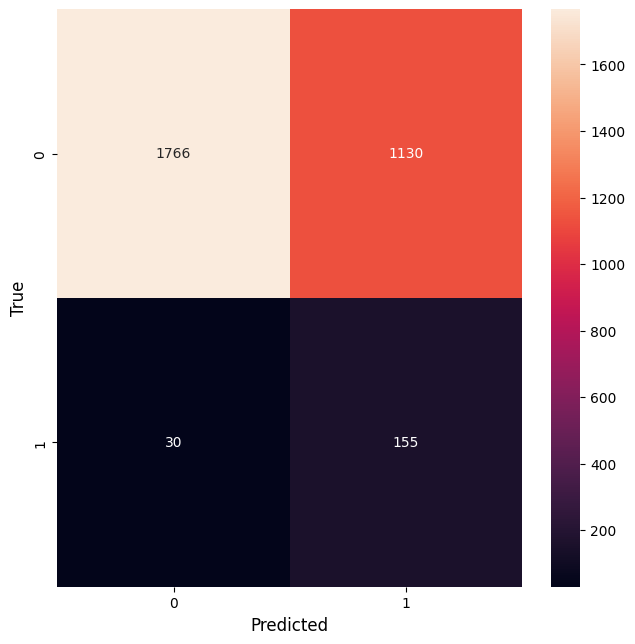

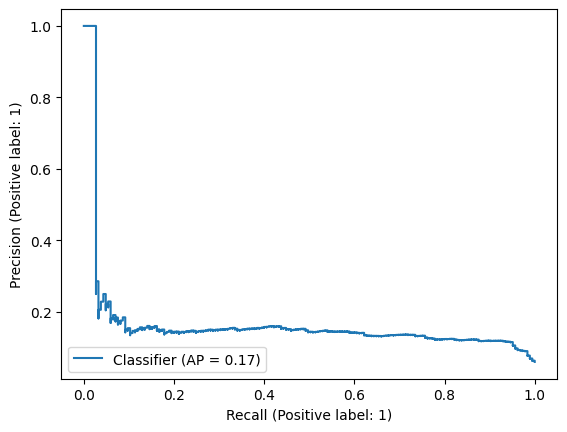

In [15]:
# one case can't get fixed, won't affect results
fixed_test_set = test.reset_index(drop=True).drop(1136, axis=0)

evaluate_model(best_pipeline_log_reg, fit_le=fit_le, test=fixed_test_set, y_col_name=y)